In [13]:
from data_fns import frequency_detection
from estimator import RFClassifier, classical_weights, haltere_inspired_weights, relu, parallelized_clf
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

In [14]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)
client

Client Scheduler: tcp://127.0.0.1:56784 Dashboard: http://127.0.0.1:56785/status,Cluster Workers: 5 Cores: 25 Memory: 8.59 GB


In [20]:
# load data
n_samples, fs, signal_duration, k, a = 5000, 1500, 0.1, 5, 0.8
X, y = frequency_detection(n_samples, fs, k, signal_duration, a, random_state=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [28]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))

# weight params
kwargs = {'lowcut': 2, 'highcut': 8}
weights_halteres = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X.shape[0]))

In [29]:
l = np.zeros_like(n_features, dtype='float')
avg_test_err = {'classical': l.copy(), 'halteres': l.copy()}
std_test_err = {'classical': l.copy(), 'halteres': l.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': 0, 'nonlinearity': relu, 'clf': sgd}
    _, _, avg_test_err['classical'][i], std_test_err['classical'][i] = parallelized_clf(RFClassifier, params_classical, X_train, y_train, X_test, y_test, n_iters=5)
    
    # haltere inspired
    params_halteres = {'width': n, **weights_halteres, 'bias': 0, 'nonlinearity': relu, 'clf': sgd} 
    _, _, avg_test_err['halteres'][i], std_test_err['halteres'][i] = parallelized_clf(RFClassifier, params_halteres, X_train, y_train, X_test, y_test, n_iters=5)

    print('Iter: %d/%d' % (i, len(n_features)))


Iter: 0/84
Iter: 1/84
Iter: 2/84
Iter: 3/84
Iter: 4/84
Iter: 5/84
Iter: 6/84
Iter: 7/84
Iter: 8/84
Iter: 9/84
Iter: 10/84
Iter: 11/84
Iter: 12/84
Iter: 13/84
Iter: 14/84
Iter: 15/84
Iter: 16/84
Iter: 17/84
Iter: 18/84
Iter: 19/84
Iter: 20/84
Iter: 21/84
Iter: 22/84
Iter: 23/84
Iter: 24/84
Iter: 25/84
Iter: 26/84
Iter: 27/84
Iter: 28/84
Iter: 29/84
Iter: 30/84
Iter: 31/84
Iter: 32/84
Iter: 33/84
Iter: 34/84
Iter: 35/84
Iter: 36/84
Iter: 37/84
Iter: 38/84
Iter: 39/84
Iter: 40/84
Iter: 41/84
Iter: 42/84
Iter: 43/84
Iter: 44/84
Iter: 45/84
Iter: 46/84
Iter: 47/84
Iter: 48/84
Iter: 49/84
Iter: 50/84
Iter: 51/84
Iter: 52/84
Iter: 53/84
Iter: 54/84
Iter: 55/84
Iter: 56/84
Iter: 57/84
Iter: 58/84
Iter: 59/84
Iter: 60/84
Iter: 61/84
Iter: 62/84
Iter: 63/84
Iter: 64/84
Iter: 65/84
Iter: 66/84
Iter: 67/84
Iter: 68/84
Iter: 69/84
Iter: 70/84
Iter: 71/84
Iter: 72/84
Iter: 73/84
Iter: 74/84
Iter: 75/84
Iter: 76/84
Iter: 77/84
Iter: 78/84
Iter: 79/84
Iter: 80/84
Iter: 81/84
Iter: 82/84
Iter: 83/84


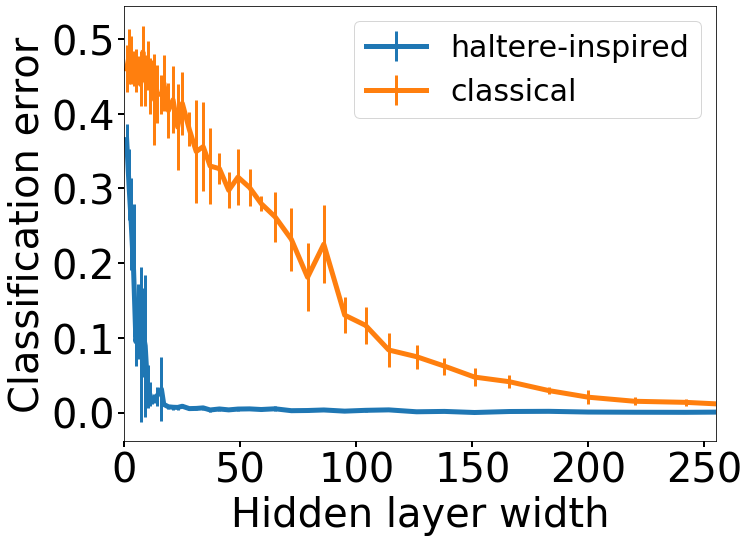

In [32]:
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, avg_test_err['halteres'], yerr=std_test_err['halteres'], fmt='-', label='haltere-inspired',  
            markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, avg_test_err['classical'], yerr=std_test_err['classical'], fmt='-', label='classical',  
            markersize=4, lw=5, elinewidth=3)
ax.set_xlim([0, 255])
plt.yticks(np.arange(0, 0.6, 0.1))
# plt.ylim([0, 0.55])
# ax.set_yscale('log')
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)
plt.legend(loc = 'upper right', fontsize=30)